<a href="https://colab.research.google.com/github/softmurata/prompt-engineering/blob/main/testnotebook/predefinedanglewithcontrolnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# KANADEMONOっていうところの素材を利用して上手く生成することが可能かどうかを確認
# 複数視点の画像が存在する
# 挿入した時の正解画像が存在している

In [ ]:
!pip install -q diffusers transformers accelerate bitsandbytes
!pip install -q controlnet_aux xformers

Create Demo Room

In [ ]:
# Get Room Image
!wget https://photo.roomhub.jp/v1/image/roomhubusercontent/297798113629863792.jpg -O /content/room.jpg
# Get Side Table Image
!wget https://static.mercdn.net/item/detail/orig/photos/m25973043998_1.jpg -O /content/sidetable.jpg
# Get Main Table
!wget https://kanademono.design/cdn/shop/products/KanademonoRubberwoodNaturalTableBlackAlineLeg_01_1080x.jpg -O /content/maintable.jpg
# Get Chair
!wget https://kanademono.design/cdn/shop/products/KanademonoSimpleDiningChairNatural_02_1080x.jpg -O /content/chair_front.jpg
!wget https://kanademono.design/cdn/shop/products/KanademonoSimpleDiningChairNatural_04_1080x.jpg -O /content/chair_back.jpg
# Get Sofa
!wget https://kanademono.design/cdn/shop/files/Stylish_Modern_FabricSofa_2seater_Charcoalgray_01_620x.jpg -O /content/sofa.jpg

In [91]:
!wget https://kanademono.design/cdn/shop/products/148813800_o2_1080x.jpg -O /content/sidetable_v2.jpg

--2023-07-31 05:13:51--  https://kanademono.design/cdn/shop/products/148813800_o2_1080x.jpg
Resolving kanademono.design (kanademono.design)... 23.227.38.65
Connecting to kanademono.design (kanademono.design)|23.227.38.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64101 (63K) [image/jpeg]
Saving to: ‘/content/sidetable_v2.jpg’

/content/sidetable_ 100%[===================>]  62.60K  --.-KB/s    in 0.01s   

2023-07-31 05:13:52 (5.22 MB/s) - ‘/content/sidetable_v2.jpg’ saved [64101/64101]



Get DemoData

In [ ]:
!wget https://kanademono.design/cdn/shop/products/KanademonoSimpleDiningChairNatural_02_1080x.jpg -O /content/chair01_frontdiagonal.jpg
!wget https://kanademono.design/cdn/shop/products/KanademonoSimpleDiningChairNatural_01_1080x.jpg -O /content/chair01_front.jpg
!wget https://kanademono.design/cdn/shop/products/KanademonoSimpleDiningChairNatural_03_1080x.jpg -O /content/chair01_side.jpg
!wget https://kanademono.design/cdn/shop/products/KanademonoSimpleDiningChairNatural_04_1080x.jpg -O /content/chair01_backdiagonal.jpg

Img2Img pipeline

In [3]:
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline
import torch
from PIL import Image
device = "cuda"
# model_id_or_path = "runwayml/stable-diffusion-v1-5"
model_id_or_path = "SG161222/Realistic_Vision_V3.0_VAE"
# pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

processor = BlipProcessor.from_pretrained("noamrot/FuseCap")
model = BlipForConditionalGeneration.from_pretrained("noamrot/FuseCap").to(device)

In [3]:
init_image = Image.open("/content/chair_front.jpg").convert("RGB")

In [4]:
text = "a picture of "
inputs = processor(init_image, text, return_tensors="pt").to(device)
out = model.generate(**inputs)
caption = processor.decode(out[0], skip_special_tokens=True)
print(caption)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (60) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a picture of a black chair with metal and black legs sits on a gray and white floor against a white wall


In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline, StableDiffusionPipeline
import torch
from PIL import Image
device = "cuda"
model_id_or_path = "SG161222/Realistic_Vision_V3.0_VAE"
pipe_img = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe_img = pipe_img.to(device)

In [2]:
# create first step latents
image = Image.open("/content/chair_front.jpg").convert("RGB")
num_inference_steps=50
batch_size = 1
num_images_per_prompt = 1
strength = 0.1
guidance_scale = 7.5
prompt = "a black chair, metal, black legs, back view"
negative_prompt = "(low quality: 1.5), (worst quality: 1.5), out of focus, (ugly: 1.5), lowers, blurry, bokeh, bad anatomy, deformed mutated disfigured,  cropped"
generator = torch.manual_seed(0)
do_classifier_free_guidance = guidance_scale > 1.0
device = pipe_img._execution_device
prompt_embeds = pipe_img._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=None,
            negative_prompt_embeds=None,
            lora_scale=None,
)

image = pipe_img.image_processor.preprocess(image)
pipe_img.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps, num_inference_steps = pipe_img.get_timesteps(num_inference_steps, strength, device)
latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)
latents = pipe_img.prepare_latents(
            image, latent_timestep, batch_size, num_images_per_prompt, prompt_embeds.dtype, device, generator
)

print(latents.shape)

torch.Size([1, 4, 135, 135])


In [ ]:
prompt = "a black chair, metal, black legs, back view"
negative_prompt = "(low quality: 1.5), (worst quality: 1.5), out of focus, (ugly: 1.5), lowers, blurry, bokeh, bad anatomy, deformed mutated disfigured,  cropped"
generator = torch.manual_seed(0)
new_image = pipe(prompt=prompt, num_inference_steps=50, generator=generator, negative_prompt=negative_prompt).images[0]

display(new_image)

Check Demo Data

In [4]:
room_path = "/content/room.jpg"
sidetable_path = "/content/sidetable.jpg"
maintable_path = "/content/maintable.jpg"
chairfront_path = "/content/chair_front.jpg"
chairback_path = "/content/chair_back.jpg"
sofa_path = "/content/sofa.jpg"

In [92]:
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
import torch
import numpy as np
from PIL import Image
import torchvision
import cv2
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "shi-labs/oneformer_ade20k_swin_large"
processor = OneFormerProcessor.from_pretrained(model_id)
model = OneFormerForUniversalSegmentation.from_pretrained(model_id).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:417: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [93]:
def extract_mask_from_item(item_name, flip_flag):
  img_path = f"/content/{item_name}.jpg"
  img = Image.open(img_path)
  semantic_inputs = processor(images=img, task_inputs=["semantic"], return_tensors="pt").to(device)
  with torch.no_grad():
    semantic_outputs = model(**semantic_inputs)

  predicted_semantic_map = processor.post_process_semantic_segmentation(semantic_outputs, target_sizes=[img.size[::-1]])[0]
  print(np.unique(predicted_semantic_map.detach().cpu().numpy()))

  obj_id = np.unique(predicted_semantic_map.detach().cpu().numpy())[-1]
  crop_mask = np.where(predicted_semantic_map.detach().cpu().numpy() == obj_id, 255, 0)
  boxes = torchvision.ops.masks_to_boxes(torch.from_numpy(crop_mask).unsqueeze(0))
  bbox_list = boxes.cpu().numpy()[0]
  center_crop_mask = crop_mask[int(bbox_list[1]):int(bbox_list[3]), int(bbox_list[0]):int(bbox_list[2])]
  center_crop = cv2.imread(img_path)[int(bbox_list[1]):int(bbox_list[3]), int(bbox_list[0]):int(bbox_list[2])]
  if not flip_flag:
    cv2.imwrite(f"/content/crop_{item_name}.jpg", center_crop)
    cv2.imwrite(f"/content/crop_{item_name}_mask.jpg", center_crop_mask)
  else:
    cv2.imwrite(f"/content/crop_{item_name}.jpg", cv2.flip(center_crop, 1))
    cv2.imwrite(f"/content/crop_{item_name}_mask.jpg", cv2.flip(center_crop_mask, 1))
  display(Image.fromarray(center_crop_mask.astype(np.uint8)))


In [ ]:
# Get mask from item
item_names = [("sidetable", False), ("maintable", False), ("chair_front", False), ("chair_back", True), ("sofa", False)]
for item_name, flip_flag in item_names:
  extract_mask_from_item(item_name, flip_flag)

In [ ]:
extract_mask_from_item("sidetable_v2", False)

In [1]:
import cv2
import numpy as np
from PIL import Image
# alpha blend
# table, crop_chair, 0.6, [0.75, 0.4], 10
def create_alphablend_image(base_img_name, add_img_name, output_img_name, res_ratio, input_ratio_list, offset_x1=10, offset_x2=10, offset_y1=10, offset_y2=10, initialize_flag=False):

  bg_img = cv2.imread(f"/content/{base_img_name}.jpg")
  bh, bw = bg_img.shape[:2]
  base_mask = np.zeros(bg_img.shape[:2])

  fg_img = cv2.imread(f"/content/{add_img_name}.jpg")
  bfh, bfw = fg_img.shape[:2]

  fg_img = cv2.resize(fg_img, (int(bfw * res_ratio), int(bfh * res_ratio)))
  fg_img_mask = cv2.resize(cv2.imread(f"/content/{add_img_name}_mask.jpg", 0), (int(bfw * res_ratio), int(bfh * res_ratio)))

  x, y = int(input_ratio_list[0] * bw), int(input_ratio_list[1] * bh)

  w = min(fg_img.shape[1], bg_img.shape[1] - x)
  h = min(fg_img.shape[0], bg_img.shape[0] - y)

  fg_roi = fg_img[:h, :w]
  bg_roi = bg_img[y: y + h, x: x + w]
  if initialize_flag:
    maxw = int(bw * 0.9)
    maxh = int(bh * 0.9)
    minw = int(bw * 0.1)
    minh = int(bh * 0.1)
  else:
    maxw = min(x + w, bw + offset_x1)
    maxh = min(y + h, bh + offset_y1)
    minw = max(0, x - offset_x2)
    minh = max(0, y - offset_y2)
  base_mask[minh:maxh, minw:maxw] = 255

  bg_roi[:] = np.where(fg_img_mask[:h, :w, np.newaxis] == 0, bg_roi, fg_roi)

  blend_img = Image.fromarray(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
  blend_mask = Image.fromarray(base_mask.astype(np.uint8))

  # display(blend_img) # please comment out for check
  # display(blend_mask)

  blend_img.save(f"/content/{output_img_name}.jpg")
  blend_mask.save(f"/content/{output_img_name}_mask.jpg")

In [2]:
# Controlnet Pipeline for stable diffusion v1.5
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import MLSDdetector, HEDdetector, CannyDetector, MLSDdetector
from transformers import pipeline

import cv2
from PIL import Image
import numpy as np
import torch

# load control net and stable diffusion v1-5
# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-mlsd", torch_dtype=torch.float16)
# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16)

# model_id = "SG161222/Realistic_Vision_V2.0"
model_id = "SG161222/Realistic_Vision_V3.0_VAE"
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     model_id, controlnet=controlnet, torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

pipe.to('cuda')

# preprocessor = MLSDdetector.from_pretrained('lllyasviel/Annotators')
depth_estimator = pipeline('depth-estimation')

def exec_controlnet_inpaint(input_img_name, output_img_name, text_prompt, seed=0, num_inference_step=50, guidance_scale=7.5, strength=0.4):

  image = Image.open(f"/content/{input_img_name}.jpg")
  mask_image = Image.open(f"/content/{input_img_name}_mask.jpg")

  # Canny
  # canny_image = cv2.Canny(np.array(image), 100, 200)
  # canny_image = canny_image[:, :, None]
  # canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
  # canny_image = Image.fromarray(canny_image)

  # HED, MLSD
  # pre_image = preprocessor(image)

  pre_image = depth_estimator(image)['depth']
  pre_image = np.array(pre_image)
  pre_image = pre_image[:, :, None]
  pre_image = np.concatenate([pre_image, pre_image, pre_image], axis=2)
  pre_image = Image.fromarray(pre_image)

  negative_prompt = "(low quality: 1.5), (worst quality: 1.5), out of focus, (ugly: 1.5), lowers, blurry, bokeh, bad anatomy, deformed mutated disfigured,  cropped"

  generator = torch.manual_seed(seed)
  new_image = pipe(
      text_prompt,
      num_inference_steps=num_inference_step,
      guidance_scale=guidance_scale,
      negative_prompt=negative_prompt,
      strength=strength,
      generator=generator,
      image=image,
      control_image=pre_image,
      mask_image=mask_image
  ).images[0]


  display(new_image)

  new_image.save(f"/content/{output_img_name}.jpg")

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
# Controlnet Pipeline for stable diffusion v2.1
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import MLSDdetector, HEDdetector, CannyDetector, MLSDdetector

import cv2
from PIL import Image
import numpy as np
import torch

# controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("thibaud/controlnet-sd21-canny-diffusers", torch_dtype=torch.float16)


model_id = "ptx0/realism-engine"
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     model_id, controlnet=controlnet, torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

pipe.to('cuda')

preprocessor = MLSDdetector.from_pretrained('lllyasviel/Annotators')

def exec_controlnet_inpaint_sd21(input_img_name, output_img_name, text_prompt, strength=0.4):
  image = Image.open(f"/content/{input_img_name}.jpg")
  mask_image = Image.open(f"/content/{input_img_name}_mask.jpg")

  canny_image = cv2.Canny(np.array(image), 100, 200)
  canny_image = canny_image[:, :, None]
  canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
  canny_image = Image.fromarray(canny_image)

  pre_image = canny_image

  generator = torch.manual_seed(1)
  new_image = pipe(
      text_prompt,
      num_inference_steps=50,
      guidance_scale=7.5,
      strength=strength,
      generator=generator,
      image=image,
      control_image=pre_image,
      mask_image=mask_image
  ).images[0]


  display(new_image)

  new_image.save(f"/content/{output_img_name}.jpg")


  0%|          | 0/32 [00:00<?, ?it/s]

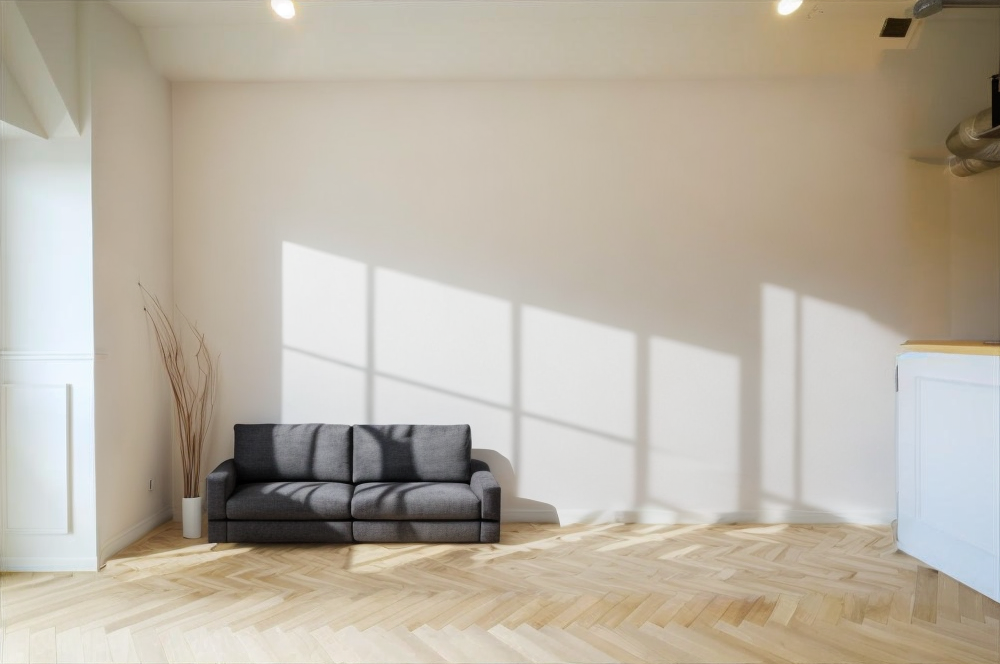

In [3]:
create_alphablend_image("room", "crop_sofa", "room_blend_v0_ab", 0.6, [0.2, 0.63], 2000, 2000, 2000, 2000, True)
exec_controlnet_inpaint("room_blend_v0_ab", "room_blend_v0", "sofa, living room, few things, comfortable, relaxing,(object shadow: 1.5), light rays, (deep shadows:1.5)", -1, 50, 7.5, 0.65)
# exec_controlnet_inpaint_sd21("room_blend_v0_ab", "room_blend_v0", "sofa", 0.5)

  0%|          | 0/20 [00:00<?, ?it/s]

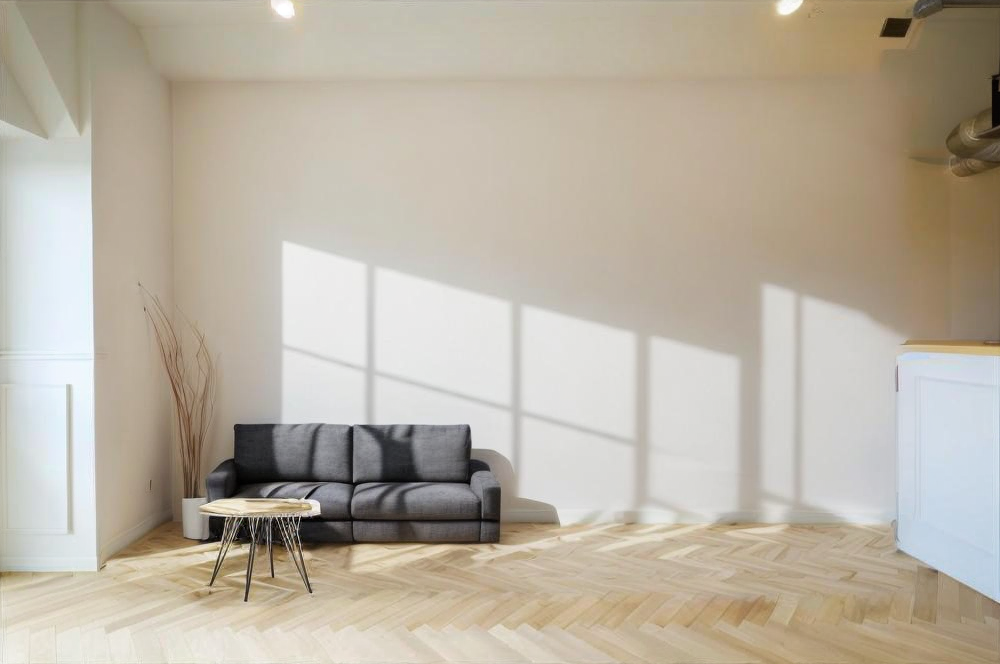

In [13]:
create_alphablend_image("room_blend_v0", "crop_sidetable", "room_blend_v1_ab", 0.25, [0.2, 0.75], 10, 10, 10, 10, False)
exec_controlnet_inpaint("room_blend_v1_ab", "room_blend_v1", "sidetable, living room, light rays, (deep shadows:1.5)", -1, 50, 7.5, 0.2)

  0%|          | 0/20 [00:00<?, ?it/s]

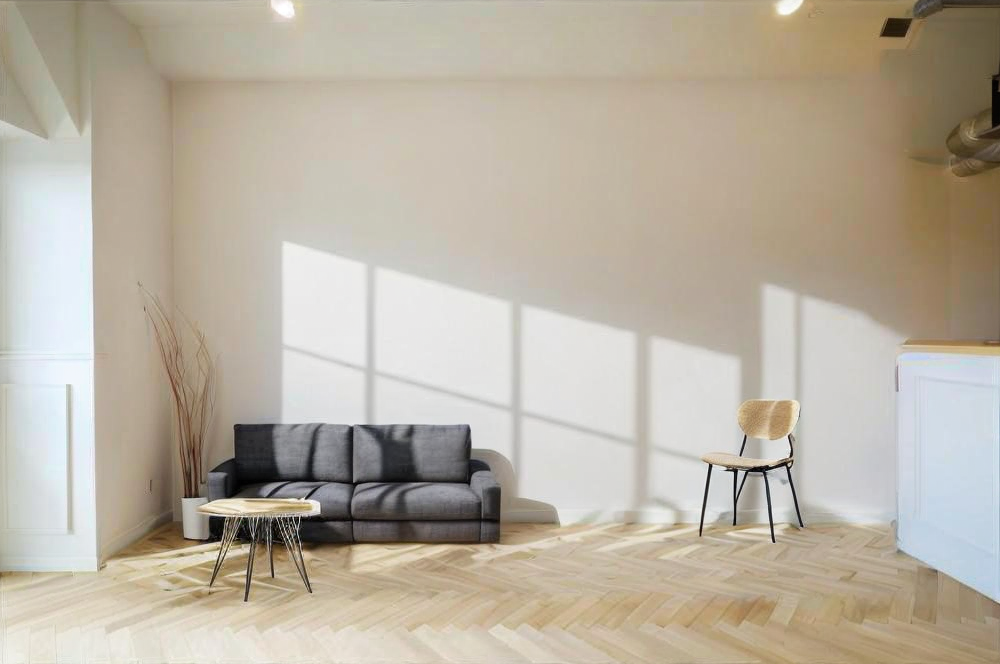

In [6]:
create_alphablend_image("room_blend_v1", "crop_chair_front", "room_blend_v2_ab", 0.2, [0.7, 0.6], 50, 50, 50, 50, False)
exec_controlnet_inpaint("room_blend_v2_ab", "room_blend_v2", "dining chair, light rays, (deep shadows:1.5)", -1, 50, 7.5, 0.4)

  0%|          | 0/27 [00:00<?, ?it/s]

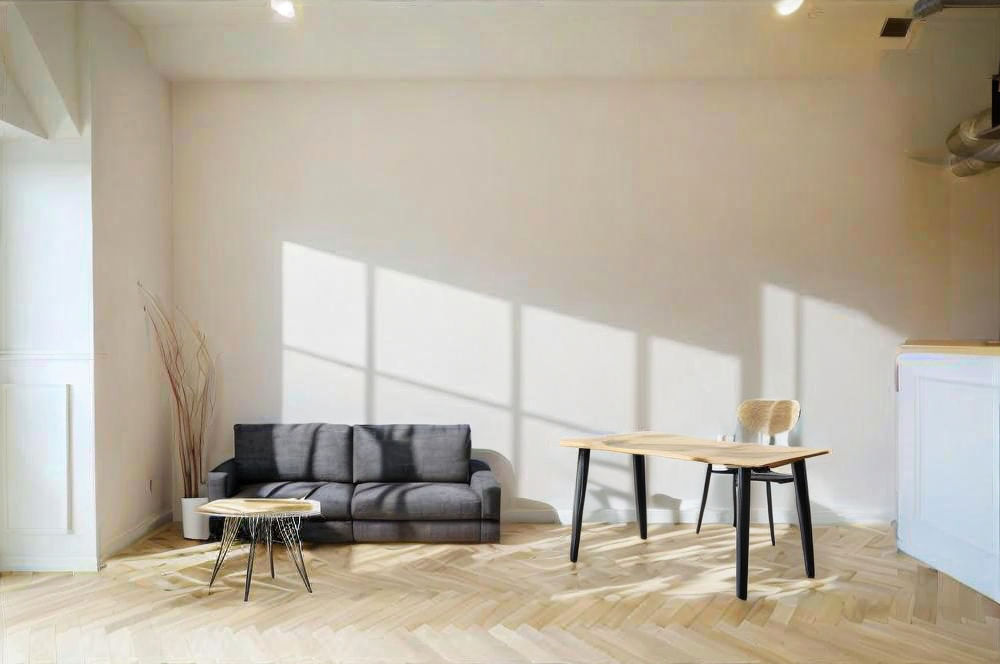

In [9]:
create_alphablend_image("room_blend_v2", "crop_maintable", "room_blend_v3_ab", 0.35, [0.55, 0.65], 50, 0, 0, 0)
exec_controlnet_inpaint("room_blend_v3_ab", "room_blend_v3", "table with thin black legs, dining room, few things, comfortable, relaxing, light rays, (deep shadows:1.5)", -1, 50, 7.5, 0.55)

  0%|          | 0/10 [00:00<?, ?it/s]

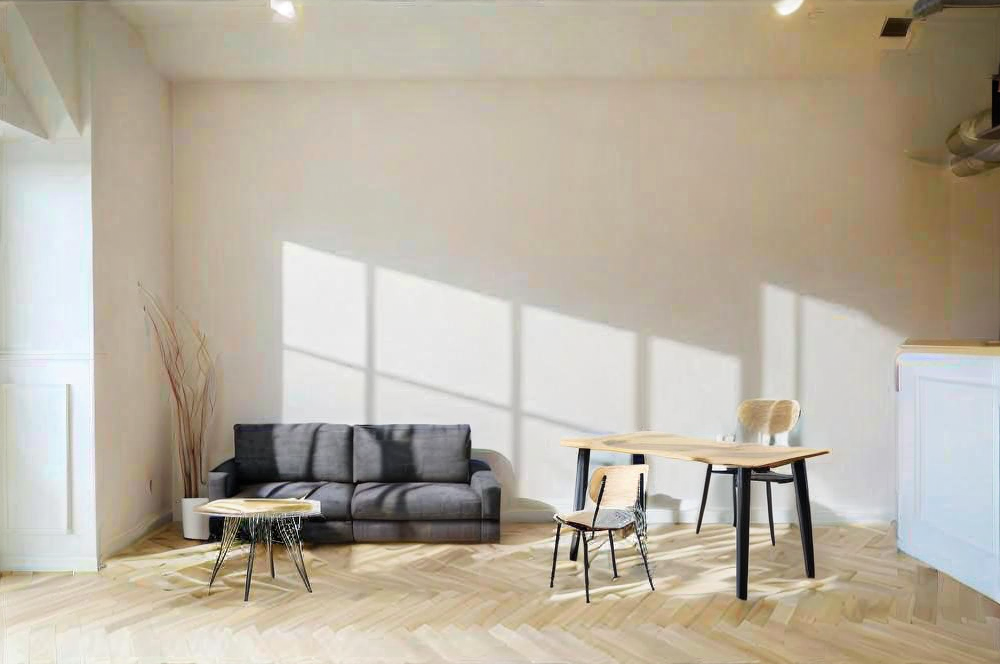

In [12]:
create_alphablend_image("room_blend_v3", "crop_chair_back", "room_blend_v4_ab", 0.2, [0.55, 0.7], 10, 10, 10, 10, False)
exec_controlnet_inpaint("room_blend_v4_ab", "room_blend_v4", "chair, dining room, light rays, (deep shadows:1.5)", -1, 50, 7.5, 0.2)

Overall Lighting

In [113]:
base_img = cv2.imread("/content/room_blend_v4.jpg")
h, w = base_img.shape[:2]
base_mask = np.zeros_like(base_img)
minh, maxh = int(0.1 * h), int(0.9 * h)
minw, maxw = int(0.1 * w), int(0.5 * w)
base_mask[minh:maxh, minw:maxw] = 255
cv2.imwrite("/content/room_blend_v4_mask.jpg", base_mask)

True

  0%|          | 0/32 [00:00<?, ?it/s]

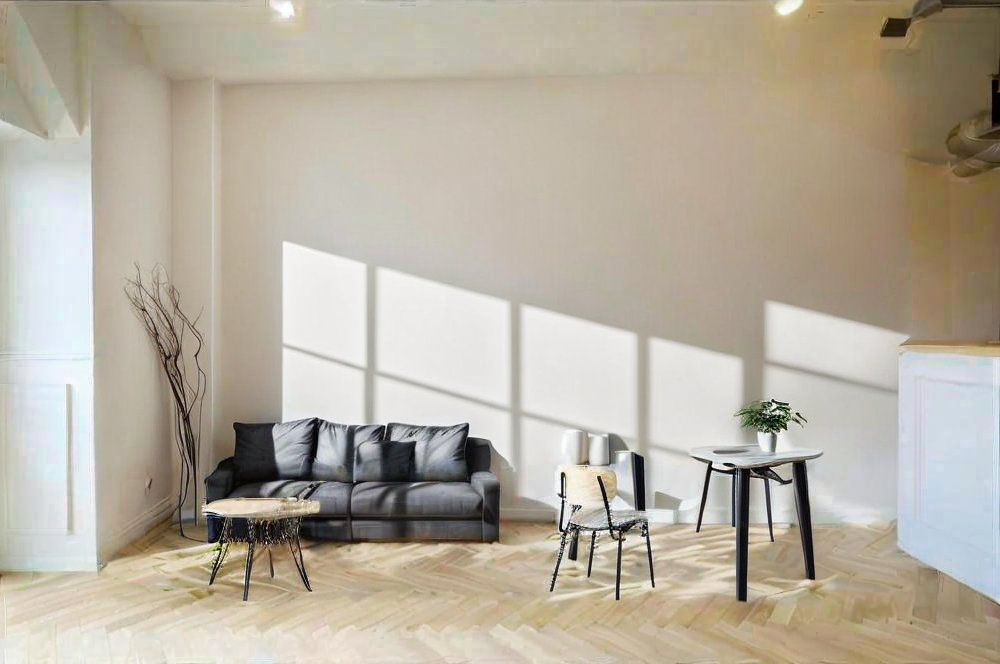

In [114]:
exec_controlnet_inpaint("room_blend_v4", "room_blend_v5", "great and comfortable white wall, picture, shelf, few things, comfortable, relaxing, light rays, (deep shadows:1.5)", -1, 50, 7.5, 0.65)

In [70]:
base_img = cv2.imread("/content/room_blend_v5.jpg")
h, w = base_img.shape[:2]
base_mask = np.zeros_like(base_img)
minh, maxh = int(0.1 * h), int(0.9 * h)
minw, maxw = int(0.5 * w), int(0.9 * w)
base_mask[minh:maxh, minw:maxw] = 255
cv2.imwrite("/content/room_blend_v5_mask.jpg", base_mask)

True

  0%|          | 0/32 [00:00<?, ?it/s]

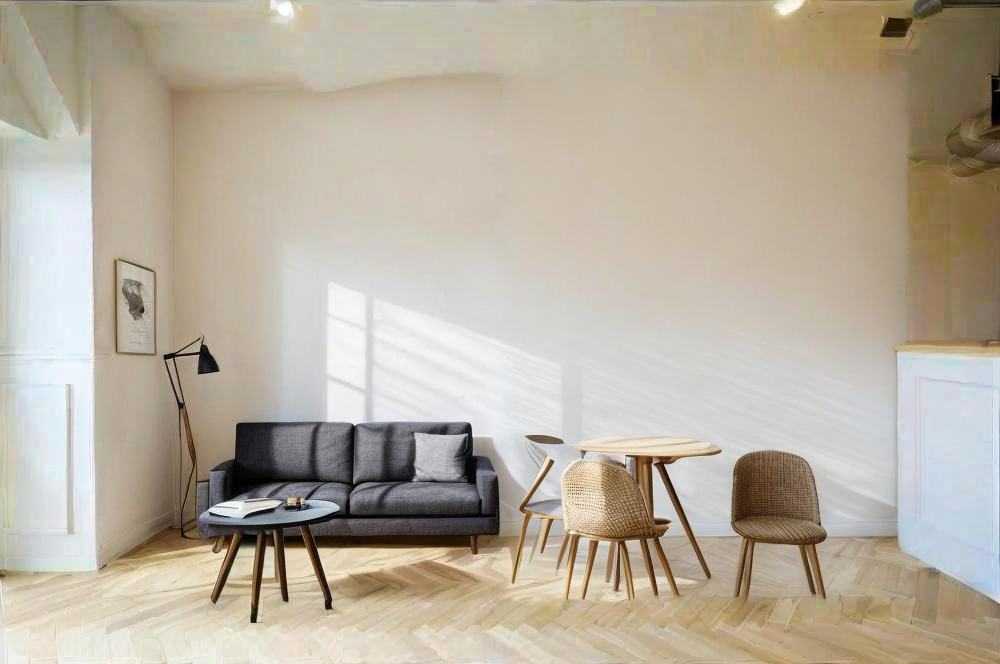

In [75]:
exec_controlnet_inpaint("room_blend_v5", "room_blend_v6", "dining room, table, chair, few things, comfortable, relaxing, light rays, (deep shadows:1.5)", -1, 50, 7.5, 0.65)

In [ ]:
# layer化していくときに若干不自然感が拭えないのでdepthとかにしてやった方が上手くいくかもしれない
# depthなのかmlsdなのか問題 -> あんまり変わらない問題
# もう少し大きくマスクを作成する必要がありそう？ちゃんと影がつかない、、
# 40 stepあれば影はついてくれる説がある→num_inference_step = 100くらいにしてstrength=0.4にするといい感じになるってこと？→そうでもなさそう
# seedのあたりの調整を加えておく必要がありそう。
# 0.3~0.6が現実とほぼ一緒だけど雰囲気には馴染みきらない感じ、0.75から馴染むけど現実から乖離し始める感じ
# 小物系統は大きく影響を受けやすい（椅子とか小さいテーブルとか）→大きなものを入れてlightingを調整ー＞小物を入れる
# text promptは正確に指定するとstrengthを強くしても崩れる確率が減る

In [ ]:
# わかったこと
# lightingについては最初にモデルルームを作成する際に定義しておく。
# 小物に関しては0.2~0.4の間でstrengthを調整、sofa, tableのような大きなものに関しては0.5~0.65でもそんなに大きくは崩れない
# 利用するモデルはdepthが良さそう

Matting ANything

In [ ]:
%cd /content
!git clone https://huggingface.co/spaces/shi-labs/Matting-Anything

In [ ]:
%cd /content/Matting-Anything
import os
os.system("export BUILD_WITH_CUDA=True")
os.system("python -m pip install -e segment-anything")
os.system("python -m pip install -e GroundingDINO")
# os.system("pip install --upgrade diffusers[torch]")
!pip install -q tensorboardX

In [ ]:
%cd /content/Matting-Anything
import os
import sys
import random
import warnings
#os.system("pip install opencv-python pycocotools matplotlib")
sys.path.insert(0, './GroundingDINO')
sys.path.insert(0, './segment-anything')
warnings.filterwarnings("ignore")

import cv2
from scipy import ndimage

import argparse

import numpy as np
import torch
from torch.nn import functional as F
import torchvision
import networks
import utils

# Grounding DINO
from groundingdino.util.inference import Model

# SAM
from segment_anything.utils.transforms import ResizeLongestSide

# SD
from diffusers import StableDiffusionPipeline

transform = ResizeLongestSide(1024)
# Green Screen
PALETTE_back = (51, 255, 146)

GROUNDING_DINO_CONFIG_PATH = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "checkpoints/groundingdino_swint_ogc.pth"
mam_checkpoint="checkpoints/mam_sam_vitb.pth"
output_dir="outputs"
device = 'cuda'
background_list = os.listdir('assets/backgrounds')

# initialize MAM
mam_model = networks.get_generator_m2m(seg='sam', m2m='sam_decoder_deep')
mam_model.to(device)
checkpoint = torch.load(mam_checkpoint, map_location=device)
mam_model.load_state_dict(utils.remove_prefix_state_dict(checkpoint['state_dict']), strict=True)
mam_model = mam_model.eval()

# initialize GroundingDINO
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH, device=device)

# initialize StableDiffusionPipeline
generator = StableDiffusionPipeline.from_pretrained("checkpoints/stable-diffusion-v1-5", torch_dtype=torch.float16)
generator.to(device)

In [22]:
from PIL import Image
import torch
import cv2
import numpy as np
import torchvision

def extract_mask_from_item_with_mam(imgname, text_prompt, flip_flag=False, box_threshold=0.25, text_threshold=0.25, iou_threshold=0.5, guidance_mode="mask"):
  image_ori = cv2.imread(f"/content/{imgname}.jpg")
  original_size = image_ori.shape[:2]

  if text_prompt is None:
    print('Please input non-empty text prompt')
  with torch.no_grad():
    detections, phrases = grounding_dino_model.predict_with_caption(
                  image=cv2.cvtColor(image_ori, cv2.COLOR_RGB2BGR),
                  caption=text_prompt,
                  box_threshold=box_threshold,
                  text_threshold=text_threshold
    )

    if len(detections.xyxy) >= 1:
      nms_idx = torchvision.ops.nms(
                  torch.from_numpy(detections.xyxy),
                  torch.from_numpy(detections.confidence),
                  iou_threshold,
      ).numpy().tolist()

      detections.xyxy = detections.xyxy[nms_idx]
      detections.confidence = detections.confidence[nms_idx]

      bbox = detections.xyxy[np.argmax(detections.confidence)]
      bbox = transform.apply_boxes(bbox, original_size)
      bbox = torch.as_tensor(bbox, dtype=torch.float).to(device)

  image = transform.apply_image(image_ori)
  image = torch.as_tensor(image).to(device)
  image = image.permute(2, 0, 1).contiguous()

  pixel_mean = torch.tensor([123.675, 116.28, 103.53]).view(3,1,1).to(device)
  pixel_std = torch.tensor([58.395, 57.12, 57.375]).view(3,1,1).to(device)

  image = (image - pixel_mean) / pixel_std

  h, w = image.shape[-2:]
  pad_size = image.shape[-2:]
  padh = 1024 - h
  padw = 1024 - w
  image = F.pad(image, (0, padw, 0, padh))

  sample = {'image': image.unsqueeze(0), 'bbox': bbox.unsqueeze(0), 'ori_shape': original_size, 'pad_shape': pad_size}


  with torch.no_grad():
      feas, pred, post_mask = mam_model.forward_inference(sample)

      alpha_pred_os1, alpha_pred_os4, alpha_pred_os8 = pred['alpha_os1'], pred['alpha_os4'], pred['alpha_os8']
      alpha_pred_os8 = alpha_pred_os8[..., : sample['pad_shape'][0], : sample['pad_shape'][1]]
      alpha_pred_os4 = alpha_pred_os4[..., : sample['pad_shape'][0], : sample['pad_shape'][1]]
      alpha_pred_os1 = alpha_pred_os1[..., : sample['pad_shape'][0], : sample['pad_shape'][1]]

      alpha_pred_os8 = F.interpolate(alpha_pred_os8, sample['ori_shape'], mode="bilinear", align_corners=False)
      alpha_pred_os4 = F.interpolate(alpha_pred_os4, sample['ori_shape'], mode="bilinear", align_corners=False)
      alpha_pred_os1 = F.interpolate(alpha_pred_os1, sample['ori_shape'], mode="bilinear", align_corners=False)

      if guidance_mode == 'mask':
          weight_os8 = utils.get_unknown_tensor_from_mask_oneside(post_mask, rand_width=10, train_mode=False)
          post_mask[weight_os8>0] = alpha_pred_os8[weight_os8>0]
          alpha_pred = post_mask.clone().detach()
      else:
          weight_os8 = utils.get_unknown_box_from_mask(post_mask)
          alpha_pred_os8[weight_os8>0] = post_mask[weight_os8>0]
          alpha_pred = alpha_pred_os8.clone().detach()


      weight_os4 = utils.get_unknown_tensor_from_pred_oneside(alpha_pred, rand_width=20, train_mode=False)
      alpha_pred[weight_os4>0] = alpha_pred_os4[weight_os4>0]

      weight_os1 = utils.get_unknown_tensor_from_pred_oneside(alpha_pred, rand_width=10, train_mode=False)
      alpha_pred[weight_os1>0] = alpha_pred_os1[weight_os1>0]

      alpha_pred = alpha_pred[0][0].cpu().numpy()

  #### draw
  ### alpha matte
  alpha_rgb = cv2.cvtColor(np.uint8(alpha_pred*255), cv2.COLOR_GRAY2RGB)

  xmin, ymin, xmax, ymax = detections.xyxy[0]
  xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
  mask = alpha_rgb[ymin:ymax, xmin:xmax, :]
  rgb = image_ori[ymin:ymax, xmin:xmax, :]

  if flip_flag:
    cv2.imwrite(f"/content/crop_{imgname}.jpg", cv2.flip(rgb))
    cv2.imwrite(f"/content/crop_{imgname}_mask.jpg", cv2.flip(mask))
  else:
    cv2.imwrite(f"/content/crop_{imgname}.jpg", rgb)
    cv2.imwrite(f"/content/crop_{imgname}_mask.jpg", mask)

  display(Image.fromarray(mask))


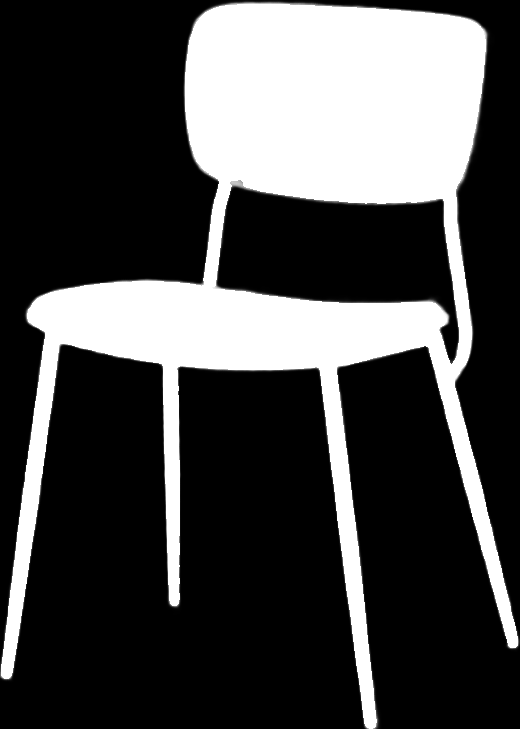

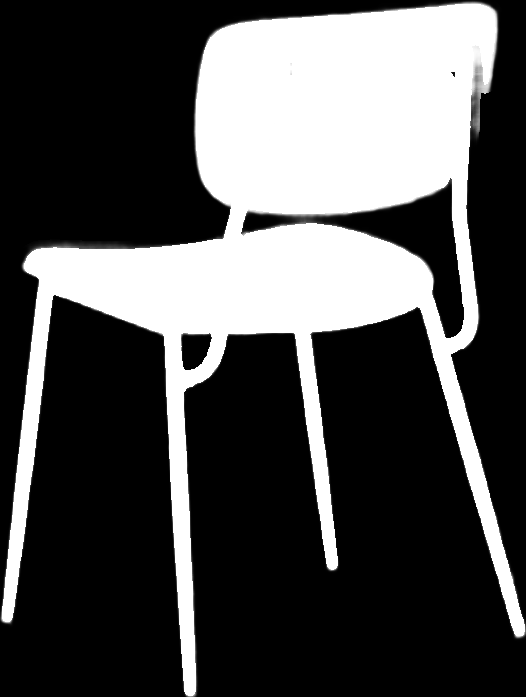

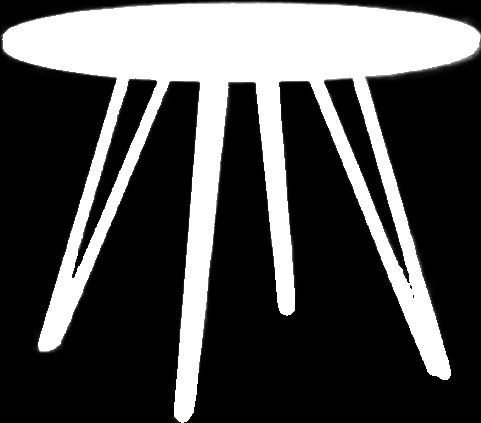

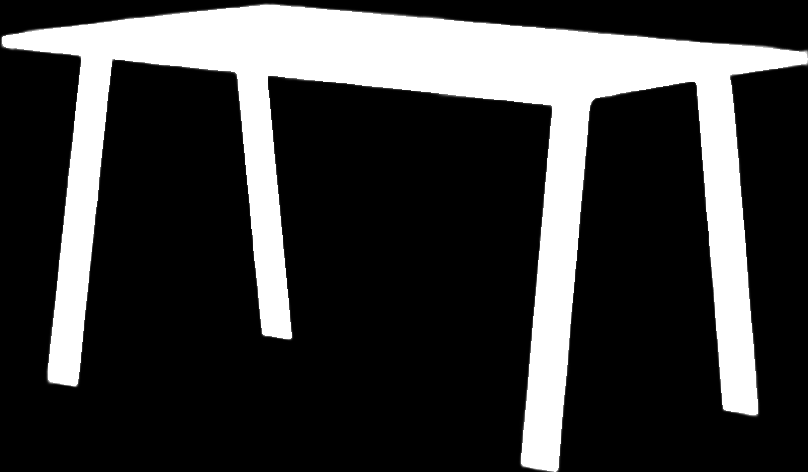

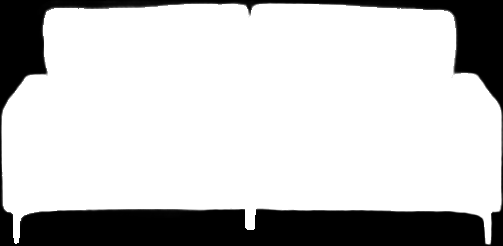

In [23]:
extract_mask_from_item_with_mam("chair_front", "chair")
extract_mask_from_item_with_mam("chair_back", "chair")
extract_mask_from_item_with_mam("sidetable", "table")
extract_mask_from_item_with_mam("maintable", "table")
extract_mask_from_item_with_mam("sofa", "sofa")